In [ ]:
!pip install stable-baselines3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

In [ ]:
import numpy as np
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.dqn.policies import CnnPolicy, MultiInputPolicy
from stable_baselines3.common.torch_layers import NatureCNN

import gymnasium as gym
from gymnasium import spaces
import numpy as np


In [ ]:
class Connect4Env(gym.Env):
    """Connect4 environment for DQN training."""
    def __init__(self):
        super().__init__()
        self.rows = 6
        self.cols = 7
        self.board = np.zeros((self.rows, self.cols), dtype=np.uint8)  # np.uint8
        self.current_player = 1
        self.action_space = spaces.Discrete(self.cols)
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, self.rows, self.cols), dtype=np.uint8)  # channel-first observation space

    def reset(self, seed=None, options=None):
        """
        Reset the environment to the initial state.
        """
        # initialize board
        self.board = np.zeros((self.rows, self.cols), dtype=np.uint8)
        self.current_player = 1

        # returns channel first array
        return np.expand_dims(self.board, axis=0), {}

    def step(self, action):
        """
        Execute one step in the environment.
        """
        if action not in self.possible_actions():
            return np.expand_dims(self.board, axis=0), -1, True, False, {}

        row = self._drop_piece(action, self.current_player)
        if self._check_win(row, action):
            reward = 1 if self.current_player == 1 else -1
            terminated = True
            truncated = False
        elif np.all(self.board != 0):
            reward = 0
            terminated = True
            truncated = False
        else:
            reward = 0
            terminated = False
            truncated = False

        self.current_player = 2 if self.current_player == 1 else 1
        return np.expand_dims(self.board, axis=0), reward, terminated, truncated, {}

    def _drop_piece(self, col, player):
        """
        Drop a piece in the specified column for the given player.
        """
        for row in reversed(range(self.rows)):
            if self.board[row, col] == 0:
                self.board[row, col] = player
                return row
        return -1

    def _check_win(self, row, col):
        """
        Check if the last move resulted in a win.
        """
        # Check horizontal, vertical, and diagonal wins (leetcode BFS stuff lol)
        directions = [
            (0, 1),  # Horizontal
            (1, 0),  # Vertical
            (1, 1),  # Diagonal (top-left to bottom-right)
            (1, -1),  # Diagonal (top-right to bottom-left)
        ]
        for dr, dc in directions:
            count = 1
            for delta in [-1, 1]:
                r, c = row + delta * dr, col + delta * dc
                while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == self.board[row, col]:
                    count += 1
                    r += delta * dr
                    c += delta * dc
            if count >= 4:
                return True
        return False

    def possible_actions(self):
        """
        Return a list of valid actions (columns that are not full).
        """
        return [col for col in range(self.cols) if self.board[0, col] == 0]

    def render(self):
        """
        Render the current state of the board.
        """
        print(self.board)
        print()

In [ ]:
import torch.nn as nn
import torch
from stable_baselines3.common.torch_layers import NatureCNN
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

class CustomCNN(BaseFeaturesExtractor):
    """
    Custom CNN architecture for Connect 4.
    """
    def __init__(self, observation_space, features_dim=512, normalized_image=False):
        super().__init__(observation_space, features_dim)
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1), # made kernel size smaller
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )

        # output dimension of the CNN
        with torch.no_grad():
            sample_input = torch.as_tensor(observation_space.sample()[None]).float()
            n_flatten = self.cnn(sample_input).shape[1]

        # define the fully connected layer
        self.linear = nn.Sequential(
            nn.Linear(n_flatten, features_dim),
            nn.ReLU(),
        )

    def forward(self, observations):
        # forward pass through the CNN
        return self.linear(self.cnn(observations))

In [ ]:
# train and save DQN with a specific policy
def train_and_save_dqn(policy, policy_name, total_timesteps=100_000):
    print(f"Training DQN with {policy_name} policy...")

    env = Connect4Env()
    env = DummyVecEnv([lambda: env])

    # DQN model with the CNN architecture
    model = DQN(
        policy,
        env,
        verbose=1,
        tensorboard_log=f"./dqn_{policy_name}_tensorboard/",
        policy_kwargs=dict(
            features_extractor_class=CustomCNN,
            features_extractor_kwargs=dict(normalized_image=False)
        )
    )

    model.learn(total_timesteps=total_timesteps)
    model.save(f"dqn_{policy_name}_connect4_model")
    print(f"Training complete. Model saved as dqn_{policy_name}_connect4_model.")

# train and save DQN with CNN Policy
train_and_save_dqn(CnnPolicy, "cnn", total_timesteps=100_000)

In [ ]:

# modified class for self play in CNN training
class Connect4EnvModified(gym.Env):
    """Connect4 environment for DQN training."""
    def __init__(self):
        super().__init__()
        self.rows = 6
        self.cols = 7
        self.board = np.zeros((self.rows, self.cols), dtype=np.uint8)  # np.uint8
        self.current_player = 1
        self.action_space = spaces.Discrete(self.cols)
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, self.rows, self.cols), dtype=np.uint8)  # channel-first observation space

    def reset(self, seed=None, options=None):
        """
        Reset the environment to the initial state.
        """
        # initialize board
        self.board = np.zeros((self.rows, self.cols), dtype=np.uint8)
        self.current_player = 1

        # returns channel first array
        return np.expand_dims(self.board, axis=0), {}

    def step(self, action):
        """
        Execute one step in the environment.
        """

        if action not in self.possible_actions():
          return np.expand_dims(self.board, axis=0), -10, True, False, {}

        # player 1 (RL) takes action
        row = self._drop_piece(action, self.current_player)
        if self._check_win(row, action):
          reward = 1 if self.current_player == 1 else -1
          terminated = True
        elif np.all(self.board != 0):
          reward = 0
          terminated = True
        else:
          reward = 0
          terminated = False

        # switch players
        self.current_player = 2 if self.current_player == 1 else 1

        return np.expand_dims(self.board, axis=0), reward, terminated, False, {}

    def _drop_piece(self, col, player):
        """
        Drop a piece in the specified column for the given player.
        """
        for row in reversed(range(self.rows)):
            if self.board[row, col] == 0:
                self.board[row, col] = player
                return row
        return -1

    def _check_win(self, row, col):
        """
        Check if the last move resulted in a win.
        """
        # Check horizontal, vertical, and diagonal wins (leetcode BFS stuff lol)
        directions = [
            (0, 1),  # Horizontal
            (1, 0),  # Vertical
            (1, 1),  # Diagonal (top-left to bottom-right)
            (1, -1),  # Diagonal (top-right to bottom-left)
        ]
        for dr, dc in directions:
            count = 1
            for delta in [-1, 1]:
                r, c = row + delta * dr, col + delta * dc
                while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == self.board[row, col]:
                    count += 1
                    r += delta * dr
                    c += delta * dc
            if count >= 4:
                return True
        return False

    def possible_actions(self):
        """
        Return a list of valid actions (columns that are not full).
        """
        return [col for col in range(self.cols) if self.board[0, col] == 0]

    def render(self):
        """
        Render the current state of the board.
        """
        print(self.board)
        print()

In [ ]:
!pip cache purge
!pip uninstall torch -y
!pip install torch

Files removed: 88
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.7/766.7 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.2/253.2 MB 5.0 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 3.1.0
    Uninstalling triton-3.1.0:
      Successfully uninstalled triton-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.5.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.
fastai 2.7.18 requires torch<2.6,>=1.10, but you have torch 2.6.0 which is incompatible.
torchvision 0.20.1+cu124 requires torch==2.5.1, but you have torch 2.6.0 which is incompatible.


In [ ]:
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt


class LossCallback(BaseCallback):
    """
    Callback to plot the loss over timesteps.
    """
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.losses = []
        self.timesteps = []

    def _on_step(self):
        # Log loss every 100 steps
        if self.n_calls % 100 == 0:
            loss = self.model.logger.name_to_value["train/loss"]
            self.losses.append(loss)
            self.timesteps.append(self.num_timesteps)
        return True

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.timesteps, self.losses, label="Training Loss")
        plt.xlabel("Timesteps")
        plt.ylabel("Loss")
        plt.title("Loss Over Timesteps")
        plt.legend()
        plt.grid()
        plt.show()



Streaming output truncated to the last 5000 lines.
|    fps              | 508      |
|    time_elapsed     | 134      |
|    total_timesteps  | 68249    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.227    |
|    n_updates        | 14562    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6324     |
|    fps              | 508      |
|    time_elapsed     | 134      |
|    total_timesteps  | 68331    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.133    |
|    n_updates        | 14582    |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 6328     |
|    fps              | 508      |
|   

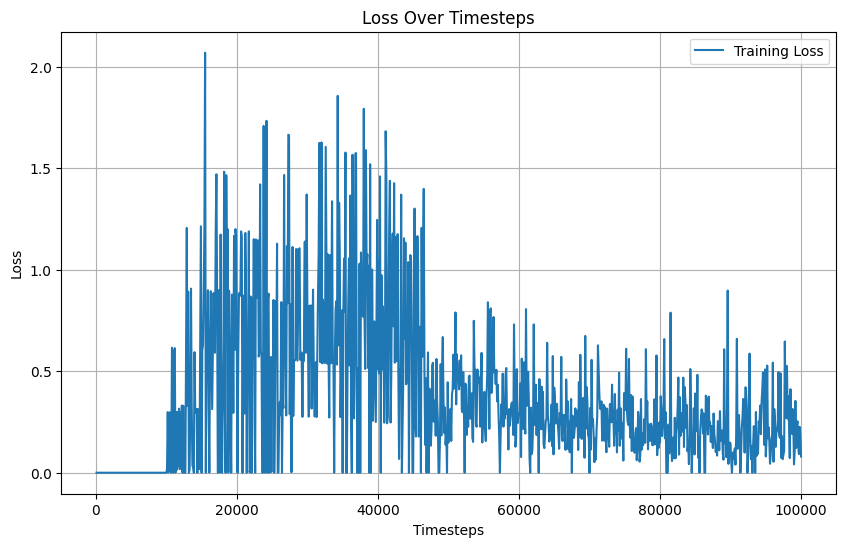

In [ ]:
# Train with self-play
def train_with_self_play(total_timesteps=100_000):
    env = Connect4EnvModified()
    env = DummyVecEnv([lambda: env])

    # Initialize the DQN model
    model = DQN(
        CnnPolicy,
        env,
        verbose=1,
        buffer_size=100_000,  # Larger replay buffer
        learning_starts=10_000,  # Start learning after 10,000 steps
        target_update_interval=1_000,  # Update target network every 1,000 steps
        tensorboard_log="./dqn_self_play_tensorboard/",
        policy_kwargs=dict(
          features_extractor_class=CustomCNN,
          features_extractor_kwargs=dict(normalized_image=False))
    )

    # Initialize the loss callback
    loss_callback = LossCallback()

    # Train the model
    model.learn(total_timesteps=total_timesteps, callback=loss_callback)

    # Save the model
    model.save("dqn_self_play_connect4_model")

    # Plot the loss
    loss_callback.plot_loss()

# Start training
train_with_self_play(total_timesteps=100_000)


Using cuda device
Logging to ./dqn_self_play_tensorboard/DQN_5
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 5963     |
|    time_elapsed     | 0        |
|    total_timesteps  | 86       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 6305     |
|    time_elapsed     | 0        |
|    total_timesteps  | 171      |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.999    |
| time/               |          |
|    episodes         | 12       |
|    fps              | 6309     |
|    time_elapsed     | 0        |
|    total_timesteps  | 232      |
---------------------------

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
|    fps              | 501      |
|    time_elapsed     | 1912     |
|    total_timesteps  | 959778   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0326   |
|    n_updates        | 227444   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 40344    |
|    fps              | 501      |
|    time_elapsed     | 1912     |
|    total_timesteps  | 959868   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00224  |
|    n_updates        | 227466   |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 40348    |
|    fps              | 501      |
|   

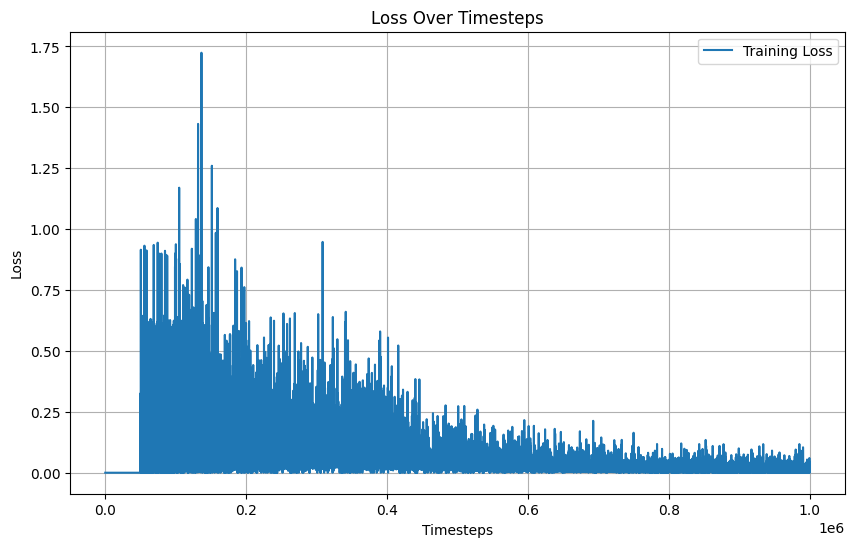

In [ ]:
# Train with self-play
def train_with_self_play(total_timesteps=100_000):
    env = Connect4EnvModified()
    env = DummyVecEnv([lambda: env])

    # Initialize the DQN model
    model = DQN(
        CnnPolicy,
        env,
        verbose=1,
        buffer_size=500_000,  # Larger replay buffer
        learning_starts=50_000,  # Start learning after 50,000 steps
        target_update_interval=5_000,  # Update target network every 5,000 steps
        exploration_fraction = 0.2, # Decay epsilon over 20% of the training steps
        exploration_final_eps = 0.1, # Minimum epsilon value
        tensorboard_log="./dqn_self_play_tensorboard/",
        policy_kwargs=dict(
          features_extractor_class=CustomCNN,
          features_extractor_kwargs=dict(normalized_image=False))
    )

    # Initialize the loss callback
    loss_callback = LossCallback()

    # Train the model
    model.learn(total_timesteps=total_timesteps, callback=loss_callback)

    # Save the model
    model.save("dqn_self_play_connect4_model")

    # Plot the loss
    loss_callback.plot_loss()

# Start training
train_with_self_play(total_timesteps=1_000_000)  # Increase training steps



In [ ]:
import torch
import stable_baselines3
print("Torch version:", torch.__version__)
print("Stable-Baselines3 version:", stable_baselines3.__version__)

Torch version: 2.5.1+cu124
Stable-Baselines3 version: 2.5.0


In [ ]:
class Connect4EnvOpponent(gym.Env):
    """Connect4 environment with a fixed opponent."""
    def __init__(self):
        super().__init__()
        self.rows = 6
        self.cols = 7
        self.board = np.zeros((self.rows, self.cols), dtype=np.uint8)
        self.current_player = 1  # RL agent always plays as Player 1
        self.action_space = spaces.Discrete(self.cols)
        self.observation_space = spaces.Box(low=0, high=255, shape=(1, self.rows, self.cols), dtype=np.uint8)

    def reset(self, seed=None, options=None):
        self.board = np.zeros((self.rows, self.cols), dtype=np.uint8)
        self.current_player = 1
        return np.expand_dims(self.board, axis=0), {}

    def step(self, action):
        """Execute one step in the environment."""
        if action not in self.possible_actions():
            return np.expand_dims(self.board, axis=0), -10, True, False, {}

        # RL Player (Player 1) moves
        row = self._drop_piece(action, self.current_player)
        if self._check_win(row, action):
            return np.expand_dims(self.board, axis=0), 1, True, False, {}

        if np.all(self.board != 0):  # Draw
            return np.expand_dims(self.board, axis=0), 0, True, False, {}

        # Switch to opponent (Player 2)
        self.current_player = 2
        opponent_action = self.opponent_move()
        row = self._drop_piece(opponent_action, self.current_player)
        if self._check_win(row, opponent_action):
            return np.expand_dims(self.board, axis=0), -1, True, False, {}

        if np.all(self.board != 0):  # Draw
            return np.expand_dims(self.board, axis=0), 0, True, False, {}

        # Switch back to RL player
        self.current_player = 1
        return np.expand_dims(self.board, axis=0), 0, False, False, {}

    def opponent_move(self):
        """Simple opponent: Blocks win, plays center, or random."""
        possible_moves = self.possible_actions()
        for move in possible_moves:
            temp_board = self.board.copy()
            row = self._drop_piece(move, 2)
            if self._check_win(row, move):
                return move  # Block winning move
            self.board = temp_board  # Reset

        if 3 in possible_moves:  # Prefer center column
            return 3

        return np.random.choice(possible_moves)

    def _drop_piece(self, col, player):
        for row in reversed(range(self.rows)):
            if self.board[row, col] == 0:
                self.board[row, col] = player
                return row
        return -1

    def _check_win(self, row, col):
        directions = [(0, 1), (1, 0), (1, 1), (1, -1)]
        for dr, dc in directions:
            count = 1
            for delta in [-1, 1]:
                r, c = row + delta * dr, col + delta * dc
                while 0 <= r < self.rows and 0 <= c < self.cols and self.board[r, c] == self.board[row, col]:
                    count += 1
                    r += delta * dr
                    c += delta * dc
            if count >= 4:
                return True
        return False

    def possible_actions(self):
        return [col for col in range(self.cols) if self.board[0, col] == 0]

    def render(self):
        print(self.board)
        print()

In [ ]:
# Train with self-play
def train_with_self_play_opponent(total_timesteps=100_000):
    env = Connect4EnvOpponent()
    env = DummyVecEnv([lambda: env])

    # Initialize the DQN model
    model = DQN(
        CnnPolicy,
        env,
        verbose=1,
        buffer_size=500_000,  # Larger replay buffer
        learning_starts=50_000,  # Start learning after 50,000 steps
        target_update_interval=5_000,  # Update target network every 5,000 steps
        exploration_fraction = 0.2, # Decay epsilon over 20% of the training steps
        exploration_final_eps = 0.1, # Minimum epsilon value
        tensorboard_log="./dqn_self_play_tensorboard/",
        policy_kwargs=dict(
          features_extractor_class=CustomCNN,
          features_extractor_kwargs=dict(normalized_image=False))
    )

    # Initialize the loss callback
    loss_callback = LossCallback()

    # Train the model
    model.learn(total_timesteps=total_timesteps, callback=loss_callback)

    # Save the model
    model.save("dqn_self_play_connect4_model")

    # Plot the loss
    loss_callback.plot_loss()

# Start training
train_with_self_play_opponent(total_timesteps=1_000_000)  # Increase training steps



Using cpu device
Logging to ./dqn_self_play_tensorboard/DQN_2
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1183     |
|    time_elapsed     | 0        |
|    total_timesteps  | 16       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1611     |
|    time_elapsed     | 0        |
|    total_timesteps  | 32       |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 1        |
| time/               |          |
|    episodes         | 12       |
|    fps              | 1735     |
|    time_elapsed     | 0        |
|    total_timesteps  | 48       |
----------------------------

KeyboardInterrupt: 